# Проект QA

## Yes/No Questions

Вы будете работать с корпусом BoolQ. Корпус состоит из вопросов, предполагающих бинарный ответ (да / нет), абзацев из Википедии,  содержащих ответ на вопрос, заголовка статьи, из которой извлечен абзац и непосредственно ответа (true / false).

Корпус описан в статье:

Christopher Clark, Kenton Lee, Ming-Wei Chang, Tom Kwiatkowski, Michael Collins, Kristina Toutanova
BoolQ: Exploring the Surprising Difficulty of Natural Yes/No Questions

https://arxiv.org/abs/1905.10044


Корпус (train-dev split) доступен в репозитории проекта:  https://github.com/google-research-datasets/boolean-questions


Каждый бонус пункт оцениватся в 1 балл. Вывод является обязательным!

### Пример вопроса: 
question: is batman and robin a sequel to batman forever

title: Batman & Robin (film)

answer: true

passage: With the box office success of Batman Forever in June 1995, Warner Bros. immediately commissioned a sequel. They hired director Joel Schumacher and writer Akiva Goldsman to reprise their duties the following August, and decided it was best to fast track production for a June 1997 target release date, which is a break from the usual 3-year gap between films. Schumacher wanted to homage both the broad camp style of the 1960s television series and the work of Dick Sprang. The storyline of Batman & Robin was conceived by Schumacher and Goldsman during pre-production on A Time to Kill. Portions of Mr. Freeze's back-story were based on the Batman: The Animated Series episode ''Heart of Ice'', written by Paul Dini.

# Соображения по методологии

# Проведение одного эксперимента
1. Подбирайте гиперпараметры! Это довольно важно. Гиперпараметры --- это размеры слоёв, например. Хотя бы в одном эксперименте это стоит сделать честно, в остальных экспериментах в принципе можно предполагать, что в предыдущем эксперименте оптимальные размеры модели уже найдены.
2. Часто вам придётся скачивать предобученные веса (вроде BERT или RoBERTa) и дообучать дополнительные веса. В таком случае стоит попробовать несколько разных подходов:
* обучать только новые (головные) слои 
* обучать совместно всю модель
* сначала обучить головные слои, потом дофайнтьюнить веса всей модели
3. Фиксируйте лучшие результаты на валидационной выборке, по валидационной же выборке останавливайте обучение
4. Графики, графики, графики
5. Делайте промежуточные выводы

# Общие соображения
1. Один эксперимент --- одно изменение! Вы не представляете, насколько это важно. Пример: для эксперимента с моделью 1 Петя для получения эмбеддингов скачал предобученные веса BERT, а для эксперимента с моделью 2 -- предобученные веса RoBERTa. Вторая модель оказалась лучше, и Петя подумал, что архитектура второй модели лучше. Но, оказывается, с весами RoBERTa модель 1 работала бы не менее хорошо. 
2. Всегда сравнивайте результаты эксперимента с результатами всех остальных экспериментов и делайте промежуточные выводы. ***Это самый важный пункт!***
3. Не забывайте протестировать модель на адекватность. Для этого нужно задавать ей реальные вопросы и смотреть на ответы. Вопросы не должны быть элементами обучающей выборки!


# git clone

In [ ]:
!git clone https://github.com/Alex-Norden/QA_BoolQ.git
%cd QA_BoolQ

Cloning into 'QA_BoolQ'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 1), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.
/content/QA_BoolQ


# Установка библиотек

In [ ]:
!pip -qq install fasttext
!pip -qq install transformers

     |████████████████████████████████| 71kB 5.3MB/s 
     |████████████████████████████████| 2.5MB 8.8MB/s 
     |████████████████████████████████| 901kB 36.6MB/s 
     |████████████████████████████████| 3.3MB 43.5MB/s 


# Импорт библиотек

In [ ]:
import os
import random
import numpy as np
import pandas as pd

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

import IPython

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [ ]:
import matplotlib.pyplot as plt

SEED = 42

def set_seed():
	np.random.seed(SEED)
	torch.random.manual_seed(SEED)
	torch.cuda.random.manual_seed(SEED)
	torch.cuda.random.manual_seed_all(SEED)

	torch.manual_seed(SEED)
	torch.backends.cudnn.deterministic = True

def plot_training(train_losses, val_losses):
	"""функция отрисовки графика обучения"""
	plt.figure(figsize=(12, 9))
	plt.subplot(2, 1, 1)
	plt.xlabel('Epoch')
	plt.plot(train_losses, label='general train history')
	plt.plot(val_losses, label='general valid history')
	plt.legend()

# Часть 1. Эксплоративный анализ (1 балл)
1. Посчитайте долю 'yes' и 'no' классов в корпусе
2. Оцените среднюю длину вопроса
3. Оцените среднюю длину параграфа
4. Предположите, по каким эвристикам были собраны вопросы (или найдите ответ в статье). Продемонстрируйте, как эти эвристики повлияли на структуру корпуса. 

In [ ]:
train_file = "boolq/train.jsonl"
dev_file = "boolq/dev.jsonl"

df_train = pd.read_json(train_file, lines=True, orient="records")
df_dev = pd.read_json(dev_file, lines=True, orient="records")

def preproc(df):
	df.answer = df.answer.astype(int)

preproc(df_train)
preproc(df_dev)

In [ ]:
def describe(df, full=False):
    if full:
        print("isna:\n{}\n".format(df.isna().sum()))

    # посчитаем долю 'yes' и 'no' классов в корпусе
    total_count = len(df.answer)
    count_yes = df.answer.sum()
    count_no = total_count - count_yes
    percent_yes = 100.0 * count_yes / total_count
    percent_no = 100.0 - percent_yes
    print("'yes' количество: {}, доля: {:.2f} %".format(count_yes, percent_yes))
    print("'no' количество: {}, доля: {:.2f} %\n".format(count_no, percent_no))

    # оценим длины заголовка, вопроса, параграфа
    df_lens = df.copy()

    for col in ('title', 'question', 'passage'):
        new_col = "len_" + col
        df_lens[new_col] = df_lens[col].apply(lambda s: len(s))
    
    df_lens.drop(['title', 'question', 'answer', 'passage'], axis=1, inplace=True)
    print(df_lens.describe())

    if full:
        # построим графики распределения длин
        def plot_distrib(col, title):
            lens = df_lens[col].values
            len_num = pd.Series(Counter(lens))

            plt.figure(figsize=(12, 5))
            plt.bar(len_num.index, len_num.values)
            plt.title(title)
            plt.show()
            print()

        plot_distrib("len_title", "Распределение длин заголовка")
        plot_distrib("len_question", "Распределение длин вопроса")
        plot_distrib("len_passage", "Распределение длин параграфа")

In [ ]:
describe(df_train)

'yes' количество: 5874, доля: 62.31 %
'no' количество: 3553, доля: 37.69 %

         len_title  len_question  len_passage
count  9427.000000   9427.000000  9427.000000
mean     20.555002     43.991938   565.613026
std      10.728475      8.854335   323.137498
min       1.000000     20.000000    35.000000
25%      13.000000     38.000000   343.000000
50%      18.000000     42.000000   511.000000
75%      26.000000     48.000000   720.000000
max      78.000000    100.000000  4720.000000


isna:
question    0
title       0
answer      0
passage     0
dtype: int64

'yes' количество: 7907, доля: 62.27 %
'no' количество: 4790, доля: 37.73 %

          len_title  len_question   len_passage
count  12697.000000  12697.000000  12697.000000
mean      20.477436     43.789635    563.923368
std       10.715538      8.598401    324.603916
min        1.000000     20.000000     35.000000
25%       13.000000     38.000000    343.000000
50%       18.000000     42.000000    508.000000
75%       26.000000     48.000000    715.000000
max       78.000000    100.000000   4781.000000


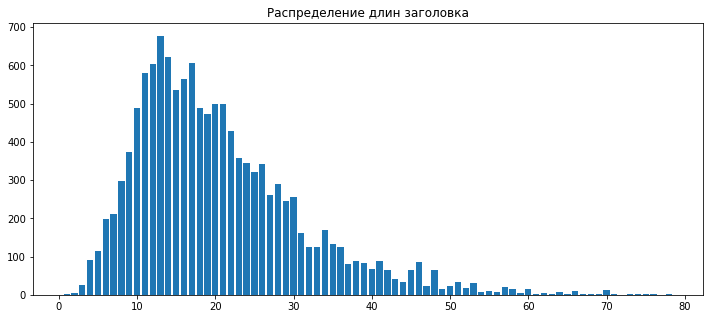

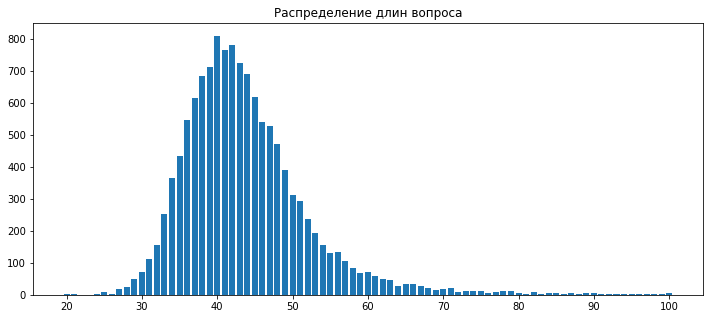

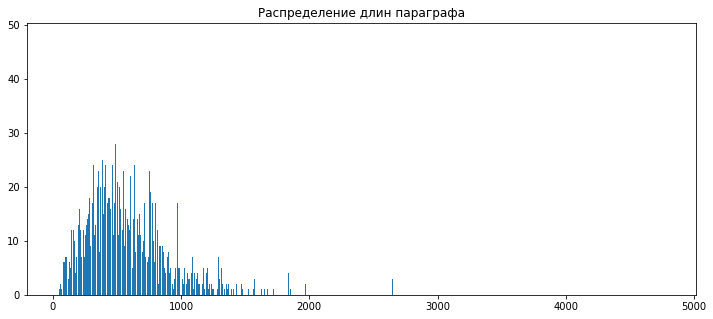

In [ ]:
df = pd.concat([df_train, df_dev])
describe(df, full=True)

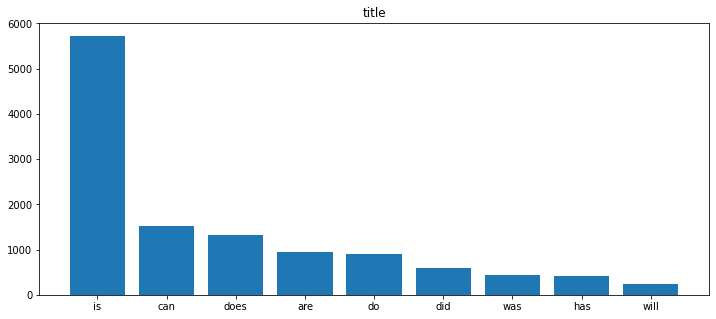

In [ ]:
df["sos"] = df["question"].apply(lambda s: s.split()[0])

words = df["sos"].values
word_num = pd.Series(Counter(words)).sort_values(ascending=False)[:9] #top 9

plt.figure(figsize=(12, 5))
plt.bar(word_num.index, word_num.values)
plt.title("title")
plt.show()

In [ ]:
print("Доля вопросов, начинающихся со служебных глаголов: {:.2f} %".format(100.0 * sum(word_num.values) / len(words)))

Доля вопросов, начинающихся со служебных глаголов: 95.59 %


Как видно, более 95% всех вопросов начинаются со служебных глаголов. Такие вопросы подразумевают ответ да/нет.

# Часть 2. Baseline (1 балл)
1. Оцените accuracy точность совсем простого базового решения: присвоить каждой паре вопрос-ответ в dev части самый частый класс из train части
2. Оцените accuracy чуть более сложного базового решения: fasttext на текстах, состоящих из склеенных вопросов и абзацев (' '.join([question, passage]))

Почему fasttext плохо справляется с этой задачей?

## Simple Baseline

In [ ]:
y_true = df_dev.answer.values
y_pred = [1]*len(y_true)
print("dev accuracy: {:.3f}".format(accuracy_score(y_true, y_pred)))
print("dev F1: {:.3f}".format(f1_score(y_true, y_pred)))

dev accuracy: 0.622
dev F1: 0.767


## FastText

In [ ]:
import fasttext

fasttext_train_path = 'fasttext_train.txt'
len_prefix = len('__label__')

def write_to_fasttext_dataset(df, res_file_path):
    inds = list(range(len(df)))
    random.shuffle(inds)
    with open(res_file_path, 'w') as fh:
        for i in inds:
            row = df.iloc[i]
            line = "__label__{} {} {}\n".format(row.answer, row.question, row.passage)
            fh.write(line)

write_to_fasttext_dataset(df_train, fasttext_train_path)
dev_input = [" ".join((row.question, row.passage)) for i, row in df_dev.iterrows()]

fasttext_model = fasttext.train_supervised(
    input=fasttext_train_path,
    dim=200, epoch=20, wordNgrams=2)

In [ ]:
preds = fasttext_model.predict(dev_input, k=1)[0]
fasttext_preds = [int(s[0][len_prefix:]) for s in preds]

print("dev accuracy: {:.3f}".format(accuracy_score(y_true, fasttext_preds)))
print("dev F1: {:.3f}".format(f1_score(y_true, fasttext_preds)))

dev accuracy: 0.686
dev F1: 0.765


Из-за несбалансированности классов fasttext плохо справляется с задачей

# Часть 3. Используем эмбеддинги предложений (2 балла)
1. Постройте BERT эмбеддинги вопроса и абзаца. Обучите логистическую регрессию на конкатенированных эмбеддингах вопроса и абзаца и оцените accuracy этого решения. 

[bonus] Используйте другие модели эмбеддингов, доступные, например, в библиотеке 🤗 Transformers. Какая модель эмбеддингов даст лучшие результаты?

[bonus] Предложите метод аугментации данных и продемонстрируйте его эффективность. 

In [ ]:
import logreg

DEVICE: cuda


In [ ]:
logreg.run_model("distilbert-base-uncased", grid_search=True)
# logreg.run_model("distilbert-base-uncased", max_length=512)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the 

embeddings...
training...
grid search...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.9min finished


best_params: {'C': 0.1, 'penalty': 'l2'}
best_score: 0.6867459347782082
best_estimator: LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
prediction...
Test Acc: 0.676 | Test F1: 0.764


(0.6758409785932722, 0.764129951045839)

In [ ]:
logreg.run_model("bert-base-uncased")
# logreg.run_model("bert-base-uncased", max_length=512)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max 

embeddings...
training...
prediction...
Test Acc: 0.678 | Test F1: 0.763


(0.6782874617737003, 0.763063063063063)

In [ ]:
logreg.run_model("roberta-base")
# logreg.run_model("roberta-base", max_length=512)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select thi

embeddings...
training...
prediction...
Test Acc: 0.651 | Test F1: 0.755


(0.6507645259938838, 0.755040755040755)

# Часть 4. Обучаем BERT на конкатенации вопроса и предложения (2 балла)

В этой части предлагается реализовать фреймворк, описанный в [видео по ссылке](https://www.youtube.com/watch?v=l8ZYCvgGu0o), адаптировав его под бинарный Question Answering. 

1. Опишите модель, которую вы будете реализовывать. Загрузите предобученный BERT, добавьте полносвязные "головные" слои. Дообучите модель: попробуйте разные способы обучения.

[bonus] Используйте модель [RoBERTa](https://arxiv.org/abs/1907.11692) вместо модели BERT. Посмотрите, что получилось.

In [27]:
import seq_clf

# For reloading
import imp
imp.reload(seq_clf)

DEVICE: cuda


<module 'seq_clf' from '/content/QA_BoolQ/seq_clf.py'>

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

training...
Epoch: 01
	Train Loss: 0.655
	 Val. Loss: 0.606 | Val. Acc: 0.683 |  Val. F1: 0.798
Epoch: 02
	Train Loss: 0.582
	 Val. Loss: 0.557 | Val. Acc: 0.733 |  Val. F1: 0.813
Epoch: 03
	Train Loss: 0.488
	 Val. Loss: 0.588 | Val. Acc: 0.707 |  Val. F1: 0.784
---------- LAST MODEL -----------
Test Loss: 0.607 | Test Acc: 0.709 | Test F1: 0.776
---------- BEST MODEL -----------
Test Loss: 0.581 | Test Acc: 0.699 | Test F1: 0.780


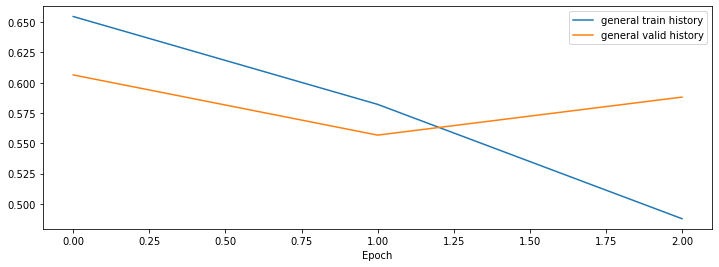

In [ ]:
history = seq_clf.run_model("bert-base-uncased")
plot_training(*history)

Теперь очередь за RoBERT'ой.

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

training...
Epoch: 01
	Train Loss: 0.623
	 Val. Loss: 0.527 | Val. Acc: 0.760 |  Val. F1: 0.841
Epoch: 02
	Train Loss: 0.474
	 Val. Loss: 0.474 | Val. Acc: 0.776 |  Val. F1: 0.831
Epoch: 03
	Train Loss: 0.369
	 Val. Loss: 0.538 | Val. Acc: 0.799 |  Val. F1: 0.852
---------- LAST MODEL -----------
Test Loss: 0.544 | Test Acc: 0.797 | Test F1: 0.845
---------- BEST MODEL -----------
Test Loss: 0.465 | Test Acc: 0.792 | Test F1: 0.834


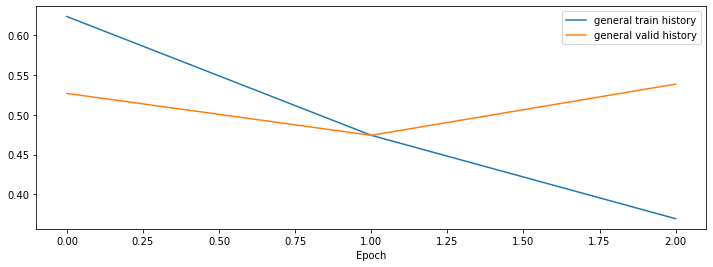

In [ ]:
history = seq_clf.run_model("roberta-base", batch_size=8, use_segment_ids=False)
plot_training(*history)

Раз RoBERTa обошла BERT, то проверим и модель побольше.

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

training...
Epoch: 01
	Train Loss: 0.613
	 Val. Loss: 0.464 | Val. Acc: 0.803 |  Val. F1: 0.863
Epoch: 02
	Train Loss: 0.422
	 Val. Loss: 0.455 | Val. Acc: 0.820 |  Val. F1: 0.868
Epoch: 03
	Train Loss: 0.372
	 Val. Loss: 0.765 | Val. Acc: 0.835 |  Val. F1: 0.878
---------- LAST MODEL -----------
Test Loss: 0.787 | Test Acc: 0.831 | Test F1: 0.868
---------- BEST MODEL -----------
Test Loss: 0.439 | Test Acc: 0.821 | Test F1: 0.861


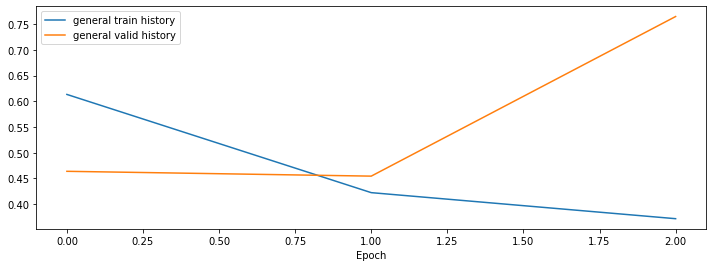

In [21]:
history = seq_clf.run_model("roberta-large", batch_size=8, use_segment_ids=False)
plot_training(*history)

Большая модель показала ещё лучшее качество. Попробуем ещё дообучить её.

In [ ]:
full_history = list(history)

In [28]:
history = seq_clf.run_model("roberta-large", batch_size=8, use_segment_ids=False, load_state=True)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

loading state...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


training...
Epoch: 01
	Train Loss: 0.338
	 Val. Loss: 0.820 | Val. Acc: 0.836 |  Val. F1: 0.877
Epoch: 02
	Train Loss: 0.183
	 Val. Loss: 0.951 | Val. Acc: 0.826 |  Val. F1: 0.873
Epoch: 03
	Train Loss: 0.232
	 Val. Loss: 0.931 | Val. Acc: 0.830 |  Val. F1: 0.870
---------- LAST MODEL -----------
Test Loss: 0.943 | Test Acc: 0.831 | Test F1: 0.863
---------- BEST MODEL -----------
Test Loss: 0.797 | Test Acc: 0.840 | Test F1: 0.873


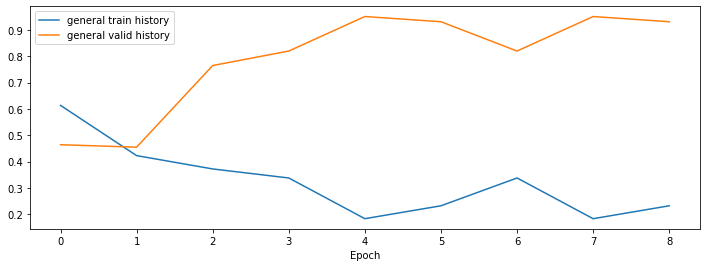

In [34]:
full_history[0].extend(history[0])
full_history[1].extend(history[1])
plot_training(*full_history)

Видим переобучение, но на тесте удалось увеличить accuracy и f1-score.

# Часть 5. BiDAF-подобная архитектура (2 балла)

Архитектура BiDAF является специфической архитектурой для QA. Здесь вам предлагается её реализовать.

Основана на статье: Bidirectional Attention Flow for Machine Comprehension

Minjoon Seo, Aniruddha Kembhavi, Ali Farhadi, Hannaneh Hajishirzi

https://arxiv.org/abs/1611.01603

Архитектура BiDAF предложена для задачи SQuAD, но легко может быть адаптирована к текущему заданию. Модель состоит из следующих блоков:
1. Кодировщик  получает на вход два представления слова: эмбеддинг слова и полученное из CNN посимвольное представление слова. Кодировщики для вопроса и для параграфа одинаковы. 
2. Слой внимания (детальное описание приведено в статье, см. пункт Attention Flow Layer)
3. Промежуточный слой, который получает на вход контекстуализированные эмбеддинги слов из параграфа, состоящие из трех частей (выход кодировщика параграфа,   Query2Context (один вектор) и Context2Query (матрица) выравнивания

4. Слой предсказания. 

Предложите, как можно было модифицировать последний слой предсказания в архитектуре BiDAF, с учетом того, что итоговое предсказание – это метка yes / no, предсказание которой проще, чем предсказание спана ответа для SQuAD.

Оцените качество этой модели для решения задачи. 

[bonus] Замените входные эмбеддинги и все дополнительные признаки, используемые кодировщиками, на BERT или RoBERTa эмбеддинги. Улучшит ли это качество результатов?

Сравнение DrQA и BiDAF:
    
![](https://www.researchgate.net/profile/Felix_Wu6/publication/321069852/figure/fig1/AS:560800147881984@1510716582560/Schematic-layouts-of-the-BiDAF-left-and-DrQA-right-architectures-We-propose-to.png)

In [35]:
import bidaf
from bidaf import Loader, BiDAF

from torchtext.vocab import GloVe

vectors = GloVe(name="6B", dim=300)
loader = Loader(32, 64, vectors, DEVICE)

config = dict(
	pretrained=loader.WORD.vocab.vectors,
	char_vocab_size=len(loader.CHAR.vocab),
	char_emb_dim=15,
	char_hidden_size=15,
	char_kernel_size=5,
	emb_dim=300,
	hidden_size=100,
	dropout=0.2)

set_seed()
model = BiDAF(**config).to(DEVICE)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


.vector_cache/glove.6B.zip: 0.00B [00:00, ?B/s]

DEVICE: cuda


.vector_cache/glove.6B.zip: 862MB [02:46, 5.17MB/s]                           
100%|█████████▉| 399442/400000 [00:37<00:00, 10266.68it/s]

building splits...


100%|█████████▉| 399442/400000 [00:49<00:00, 10266.68it/s]

building vocab...
building iterators...


Epoch: 01
	Train Loss: 0.653
	 Val. Loss: 0.653 | Val. Acc: 0.624 |  Val. F1: 0.744
Epoch: 02
	Train Loss: 0.611
	 Val. Loss: 0.654 | Val. Acc: 0.628 |  Val. F1: 0.713
Epoch: 03
	Train Loss: 0.559
	 Val. Loss: 0.656 | Val. Acc: 0.631 |  Val. F1: 0.701
Epoch: 04
	Train Loss: 0.482
	 Val. Loss: 0.668 | Val. Acc: 0.657 |  Val. F1: 0.768
Epoch: 05
	Train Loss: 0.378
	 Val. Loss: 0.693 | Val. Acc: 0.643 |  Val. F1: 0.726
Epoch: 06
	Train Loss: 0.269
	 Val. Loss: 0.857 | Val. Acc: 0.671 |  Val. F1: 0.748
Epoch: 07
	Train Loss: 0.184
	 Val. Loss: 1.096 | Val. Acc: 0.647 |  Val. F1: 0.727
Epoch: 08
	Train Loss: 0.134
	 Val. Loss: 1.200 | Val. Acc: 0.660 |  Val. F1: 0.730
Epoch: 09
	Train Loss: 0.093
	 Val. Loss: 1.403 | Val. Acc: 0.648 |  Val. F1: 0.712
Epoch: 10
	Train Loss: 0.077
	 Val. Loss: 1.396 | Val. Acc: 0.653 |  Val. F1: 0.725


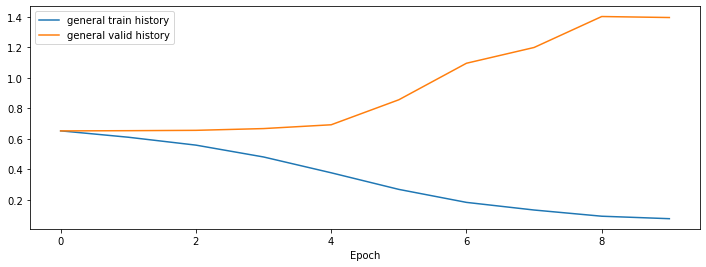

In [36]:
n_epochs = 10
clip = 3

# optimizer = torch.optim.Adadelta(model.parameters(), lr=0.5)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

history = bidaf.train_loop(
    model,
    optimizer,
    criterion,
    loader.train_iter,
    loader.val_iter,
    n_epochs,
    clip)
plot_training(*history)

In [37]:
bidaf.test(model, criterion, loader.test_iter, to_print=True)

Test Loss: 1.389 | Test Acc: 0.662 | Test F1: 0.731


(1.3894592294326196, 0.6620795107033639, 0.7313396547532214)

In [38]:
best_model = BiDAF(**config).to(DEVICE)
best_model.load_state_dict(torch.load(bidaf.BEST_MODEL_PATH))

<All keys matched successfully>

In [39]:
bidaf.test(best_model, criterion, loader.test_iter, to_print=True)

Test Loss: 0.878 | Test Acc: 0.657 | Test F1: 0.740


(0.8779690999251145, 0.6565749235474007, 0.7401064568386948)

# Часть 6. Итоги (2 балла)
Напишите краткое резюме проделанной работы. Сравните результаты всех разработанных моделей. Что помогло вам в выполнении работы, чего не хватало?

**Simple Baseline**

Accuracy простого базового решения на тесте составляет 62.2%, f1-score 76.7%.

**FastText**

Чуть более сложное решение с использованием FastText позволяет повысить accuracy до 68.6%, f1-score составляет 76.5%.

**LogisticRegression (Transformers-эмбеддинги)**

Для получения эмбеддингов использовались DistilBERT, BERT, RoBERTa. Лучше других с задачей справился BERT, который лишь немного обошёл DistilBERT'a.

С логистической регрессией на конкатенированных эмбеддингах вопроса и абзаца удалось получить на тесте accuracy 67.8% и f1-score 76.3%. Немного хуже подхода с FastText.

**Transformers for Sequence Classification**

BERT-base, обученный на конкатенированных вопросах и параграфах, превзошёл по качеству предыдущие модели.

RoBERTa-base улучшила качество, а 'её старшая сестра' RoBERTa-large ещё улучшила и показала на тесте accuracy 84% и f1-score 87.3%.

**BiDAF**

В качестве входных эмбеддингов использовал GloVe.
Модель довольно быстро переобучается.
Удалось получить на тесте accuracy 66.2% и f1-score 73.1%.





# Дополнительные ресурсы:

In [ ]:
https://drive.google.com/drive/folders/1fO87dcVFr9yPBFE1CgGu_pBY45pt-yr8
https://github.com/pytorch/examples
https://github.com/huggingface/transformers
https://arxiv.org/abs/1810.04805
https://arxiv.org/abs/1907.11692
https://colab.research.google.com/drive/1T94TTX_3kVYrEnzKrGFKrJ3y5WfJJ4zq
https://colab.research.google.com/drive/1uSlWtJdZmLrI3FCNIlUHFxwAJiSu2J0-
https://github.com/allenai/bi-att-flow
https://torchtext.readthedocs.io/en/latest/
https://github.com/galsang/BiDAF-pytorch
https://github.com/svinkapeppa/MIPT_NLP_2020
https://towardsdatascience.com/the-definitive-guide-to-bi-directional-attention-flow-d0e96e9e666b